In [2]:
import tensorflow as tf

# GPU 확인
tf.test.is_gpu_available( cuda_only=False, min_cuda_compute_capability=None )

True

In [48]:
%matplotlib inline
import datetime as dt
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
from dateutil.parser import parse

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [49]:
print(tf.__version__)

print(tf.keras.__version__)

print(pd.__version__)

2.0.0
2.2.4-tf
1.0.1


In [50]:
# 파일 불러오기 예시
# pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/train.csv')

# 4319
data = pd.read_csv('result.csv', encoding='cp949').set_index('date')
print(data.shape)
data.head(2)

(1501, 27)


,stock_Asia,stock_Jobi,stock_Hyosung,stock_Farming,stock_Namhae_Chemical,stock_KGChemical,stock_Nongwoo_Bio,stock_Sungbo_Chemical,stock_Asia_Tech,stock_Eastern_Agro,...,cabbage,cabbage1,onion,carrot,green_onion,cucumber,price_egg,price_milk,exchangerate,kospi
date,,,,,,,,,,,,,,,,,,,,,
2014-08-01,3300.0,12000.0,17300.0,5780.0,9260.0,13700.0,20650.0,42350.0,3455.0,6380.0,...,5388.0,5534.0,593.0,39369.0,1156.0,62722.0,5987.0,2549.0,1037.75,2073.10
2014-08-04,3300.0,12000.0,17350.0,5900.0,9280.0,13700.0,21100.0,43050.0,3465.0,6370.0,...,9059.0,4286.0,600.0,41218.0,1510.0,43128.0,5987.0,2549.0,1033.35,2080.42


In [51]:
data.loc[str(parse(data.index[-1]).date() + timedelta(days=1))] = [np.nan for _ in range(data.shape[1])]

In [52]:
data.tail(2)

,stock_Asia,stock_Jobi,stock_Hyosung,stock_Farming,stock_Namhae_Chemical,stock_KGChemical,stock_Nongwoo_Bio,stock_Sungbo_Chemical,stock_Asia_Tech,stock_Eastern_Agro,...,cabbage,cabbage1,onion,carrot,green_onion,cucumber,price_egg,price_milk,exchangerate,kospi
date,,,,,,,,,,,,,,,,,,,,,
2020-03-31,3750.0,12350.0,5400.0,9580.0,6990.0,10850.0,8800.0,3300.0,3590.0,5400.0,...,7887.0,12311.0,1279.0,68390.0,844.0,43002.0,5311.0,2623.0,1218.8,1754.64
2020-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
target_name = 'stock_Asia'
target_names = [target_name]
#df = data[]
shift_steps = 1

df = data[target_names].shift(1)

df.tail(3)

,stock_Asia
date,
2020-03-30,2885.0
2020-03-31,2885.0
2020-04-01,3750.0


In [9]:
df_targets = df[target_name].shift(-shift_steps)
# df_targets = df.shift(-shift_steps)

df_targets.tail(3)

date
2020-03-30    2885.0
2020-03-31    3750.0
2020-04-01       NaN
Name: stock_Asia, dtype: float64

In [38]:
df.index[-65:]

Index(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07', '2020-01-08',
       '2020-01-09', '2020-01-10', '2020-01-13', '2020-01-14', '2020-01-15',
       '2020-01-16', '2020-01-17', '2020-01-20', '2020-01-21', '2020-01-22',
       '2020-01-23', '2020-01-24', '2020-01-27', '2020-01-28', '2020-01-29',
       '2020-01-30', '2020-01-31', '2020-02-03', '2020-02-04', '2020-02-05',
       '2020-02-06', '2020-02-07', '2020-02-10', '2020-02-11', '2020-02-12',
       '2020-02-13', '2020-02-14', '2020-02-17', '2020-02-18', '2020-02-19',
       '2020-02-20', '2020-02-21', '2020-02-24', '2020-02-25', '2020-02-26',
       '2020-02-27', '2020-02-28', '2020-03-02', '2020-03-03', '2020-03-04',
       '2020-03-05', '2020-03-06', '2020-03-09', '2020-03-10', '2020-03-11',
       '2020-03-12', '2020-03-13', '2020-03-16', '2020-03-17', '2020-03-18',
       '2020-03-19', '2020-03-20', '2020-03-23', '2020-03-24', '2020-03-25',
       '2020-03-26', '2020-03-27', '2020-03-30', '2020-03-31', '2020-04-01']

In [11]:
x_data = df.values[shift_steps:-23] # 3월 예측

print(type(x_data))
print("Shape:", x_data.shape)
y_data = df_targets.values[shift_steps:-23].reshape(-1,1)

print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (1478, 1)
<class 'numpy.ndarray'>
Shape: (1478, 1)


In [12]:
num_data = len(x_data)
print(num_data)
train_split = 0.9

num_train = int(train_split * num_data)
print(num_train)

num_test = num_data - num_train
print(num_test)

x_train = x_data[0:num_train]
x_test = x_data[num_train:]
print(len(x_train) + len(x_test))

y_train = y_data[0:num_train]
y_test = y_data[num_train:]
print(len(y_train) + len(y_test))

1478
1330
148
1478
1478


In [13]:
# input 갯수
num_x_signals = x_data.shape[1]
# output 갯수
num_y_signals = y_data.shape[1]

print('input ouput 갯수 :',num_x_signals, num_y_signals)

input ouput 갯수 : 1 1


In [14]:
# Scaled Data
x_scaler = MinMaxScaler()

x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
# print("Min:", np.min(x_train_scaled))
# print("Max:", np.max(x_train_scaled))

In [15]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [16]:
batch_size = 256
sequence_length = 365
warmup_steps = 100

generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)
x_batch, y_batch = next(generator)

print(x_batch.shape)
print(y_batch.shape)

(256, 365, 1)
(256, 365, 1)


In [17]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [18]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

def init_model():
    model = Sequential()

    model.add(GRU(units=512,
                  return_sequences=True,
                  input_shape=(None, num_x_signals,)))

    model.add(Dense(num_y_signals, activation='sigmoid'))

    optimizer = RMSprop(lr=1e-3)

    model.compile(loss=loss_mse_warmup, optimizer=optimizer)

    model.summary()

    return model

model = init_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         791040    
_________________________________________________________________
dense (Dense)                (None, None, 1)           513       
Total params: 791,553
Trainable params: 791,553
Non-trainable params: 0
_________________________________________________________________


In [19]:
model

In [20]:
# model.load_weights('/content/gdrive/My Drive/Colab Notebooks/Bit_project/model1.h5')# Re-evaluate the model

In [21]:
# path_checkpoint = '/content/gdrive/My Drive/Colab Notebooks/Bit_project/23_checkpoint.keras'
# callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
#                                       monitor='val_loss',
#                                       verbose=1,
#                                       save_weights_only=True,
#                                       save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

# callback_tensorboard = TensorBoard(log_dir='/content/gdrive/My Drive/Colab Notebooks/Bit_project/23_logs/',
#                                    histogram_freq=0,
#                                    write_graph=False)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_reduce_lr]

In [22]:
%%time
model.fit(x=generator,
          epochs=20,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

Train for 100 steps, validate on 1 samples
Epoch 1/20
100/100 [==============================] - 16s 163ms/step - loss: 0.0113 - val_loss: 0.0011
Epoch 2/20
100/100 [==============================] - 12s 122ms/step - loss: 0.0031 - val_loss: 7.4744e-04
Epoch 3/20
100/100 [==============================] - 13s 126ms/step - loss: 0.0022 - val_loss: 5.6667e-04
Epoch 4/20
100/100 [==============================] - 13s 127ms/step - loss: 0.0018 - val_loss: 4.6652e-04
Epoch 5/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 12s 124ms/step - loss: 0.0016 - val_loss: 5.5423e-04
Epoch 6/20
100/100 [==============================] - 13s 127ms/step - loss: 0.0012 - val_loss: 2.7109e-04
Epoch 7/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0001.
100/100 [=====================

In [23]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    signal = 0
    
    # Get the output-signal predicted by the model.
    signal_pred = y_pred_rescaled[:, signal]
    
    # Get the true output-signal from the data-set.
    signal_true = y_true[:, signal]

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))
    
    # Plot and compare the two signals.
    plt.plot(signal_true, label='true')
    plt.plot(signal_pred, label='pred')
    
    # Plot grey box for warmup-period.
    p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
    
    # Plot labels etc.
    plt.ylabel(target_names[signal])
    # plt.xlabel(np.array(dt_index.date))
    
    plt.legend()
    plt.show()

    # return signal_true, signal_pred

def pred(model):
    '''
    수익률 계산을 위한 실제 주식값, 예측 주식값 생성
    '''
    pred_x_data = df.values[shift_steps:-1]
    y_true = np.array(df_targets.values[shift_steps:-1], dtype=np.int)# .reshape(-1,1)

    #print(y_true[-10:])

    pred_x_train_scaled = x_scaler.fit_transform(pred_x_data)
    # y_true_scaled = y_scaler.transform(y_true)

    pred_x = np.expand_dims(pred_x_train_scaled, axis=0)

    pred = model.predict(pred_x)

    pred_rescaled = y_scaler.inverse_transform(pred[0])

    pred = pred_rescaled[:, 0].astype(np.int)

    return y_true, pred

def returns(true, pred, term):
    '''
    수익률 계산
    계산 방법 : 
      당일 예측값 - 전일 예측값 > 0 매도
      당일 예측값 - 전일 예측값 < 0 미구매

      매도 했을 경우 실제 값의 변동의 총 합 / 주어진 기간의 실제 주식 가격 평균 * 100 (단위 : %)
    '''
    true_data = true[-term:]
    pred_data = pred[-term:]


    sum_true_data = true_data[1:] - true_data[:-1]
    sum_pred_data = pred_data[1:] - pred_data[:-1]

    returns = 1

    for idx, i in enumerate(sum_pred_data):
        daily_yield = (sum_true_data[idx] / true_data[idx]) + 1
        if i > 0:
          # print(daily_yield)
          returns *= daily_yield

    return returns

In [24]:
df.values[shift_steps:]

array([[3300.],
       [3300.],
       [2805.],
       ...,
       [2885.],
       [2885.],
       [3750.]])

In [26]:
pred(model)

(array([3300, 2805, 2805, ..., 2885, 2885, 3750]),
 array([4867, 4283, 3901, ..., 3591, 3638, 3635]))

In [39]:
t,p = pred(model)
# `20년 3월 한달간 수익률
returns(t,p, 65)

1.176710516777822

In [47]:
# returns_lst = pd.DataFrame(columns = ['name','error','returns','stock_name']).set_index('name')
# returns_lst
returns_lst = pd.read_csv('returns_lst.csv', encoding='cp949').set_index('name')

returns_lst

,error,returns,stock_name
name,,,
['stock_Asia'],0.00029,1.239,stock_Asia


In [41]:
# result_lst = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Bit_project/result_lst.csv', encoding='cp949').set_index('name')

# result_lst

# # result_lst = pd.DataFrame(columns = ['name','error','returns']).set_index('name')
# result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
#                         y=np.expand_dims(y_test_scaled, axis=0))

# print("loss (test-set):", result)

# result_lst.loc[str([str(i) for i in df.columns])] = [round(result,5), round(returns(t, p, 23),3), target_name]
# # result_lst.append([str([str(i) for i in df.columns]), (round(result,5))])
# result_lst[result_lst['stock_name'] == target_name].sort_values(by = ['returns','error'], ascending=[False, True])

In [42]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

print("loss (test-set):", result)

returns_lst.loc[str([str(i) for i in df.columns])] = [round(result,5), round(returns(t, p, 23),3), target_name]
# result_lst.append([str([str(i) for i in df.columns]), (round(result,5))])
returns_lst[returns_lst['stock_name'] == target_name].sort_values(by = ['returns','error'], ascending=[False, True])

1/1 [==============================] - 0s 23ms/sample - loss: 2.9233e-04
loss (test-set): 0.0002923345600720495


,error,returns,stock_name
name,,,
['stock_Asia'],0.00029,1.239,stock_Asia


In [43]:
result = returns_lst.sort_values(by = ['returns','error'], ascending=[False, True])#.set_index('name')
result.to_csv('returns_lst.csv')
result

,error,returns,stock_name
name,,,
['stock_Asia'],0.00029,1.239,stock_Asia


In [44]:
# model save
from tensorflow.keras.models import load_model
model.save('model/' + str([str(i) for i in df.columns]) + '.h5')

In [45]:
result['stock_name'].unique()

array(['stock_Asia'], dtype=object)

In [46]:
result[result['stock_name'] == 'stock_Jobi']

,error,returns,stock_name
name,,,


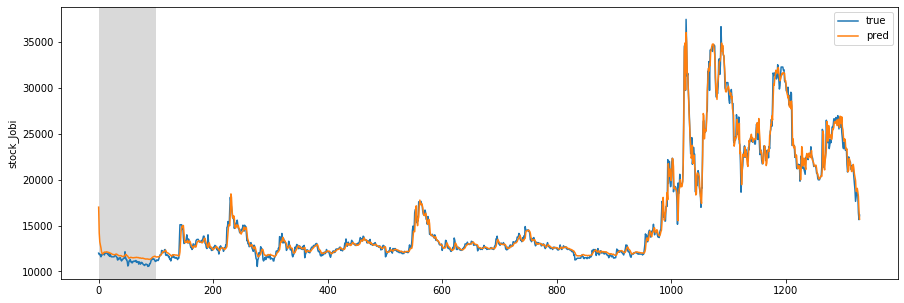

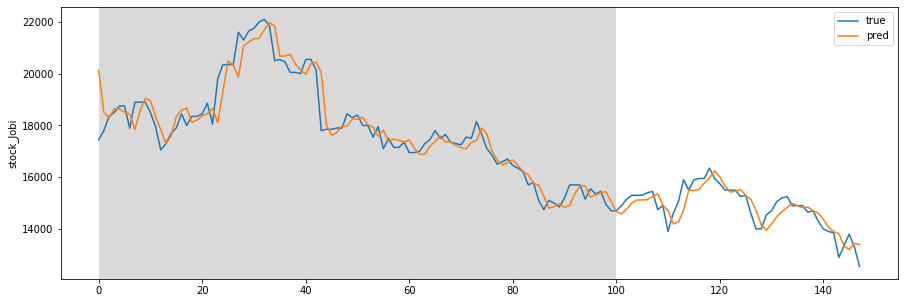

In [339]:
# stock_asia을 이용한 예측
plot_comparison(start_idx=0, length=len(y_train), train=True)
plot_comparison(start_idx=0, length=len(y_test), train=False)